# Coffee Supply Chain (using excel)

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Complete"


**Import modules**

In [1]:
import sys
sys.path.append('../../src')

In [ ]:
import pandas 
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, ProcessMode, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.components.result import Result 
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.solve import solve
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX

**Input Data**

In [273]:
input_ = 'coffee.xlsx'

In [274]:

resource_input = pandas.read_excel(input_, sheet_name= 'Resources', index_col= 'name')
process_input = pandas.read_excel(input_, sheet_name= 'Processes')
conversion = pandas.read_excel(input_, sheet_name= 'Conversion', index_col= 'process')
demand_factor = pandas.read_excel(input_, sheet_name= 'DemandFactors')


In [275]:
demand_factor

,coffee_brewed
0,1.0
1,0.9
2,0.9
3,1.0
4,0.6
5,0.4
6,0.4


**Declare temporal scale**


Consider four seasons in a year.

Network decisions are taken annually (scale level 0)

Scheduling decisions are taken seasonally (scale level 1)


In [276]:
scales = TemporalScale(discretization_list= [len(demand_factor)])

**Declare resources**

Resources can be declared with attributes such as maximum consumption (cons_max), resource price (price), maximum allowed inventory (store_max)

As also whether they can be discharged (sell), have to meet demand (demand)

In [277]:
resource_list = []
for i in range(len(resource_input.index)):
    resource_list.append(Resource(name= resource_input.index[i], cons_max= resource_input['cons_max'][i], loss = resource_input['loss'][i], \
        revenue = resource_input['revenue'][i], price = resource_input['price'][i], store_max = resource_input['store_max'][i], \
            store_min = resource_input['store_min'][i], sell = bool(resource_input['sell'][i]), demand = bool(resource_input['demand'][i]), \
                basis = resource_input['basis'][i], block = resource_input['block'][i], varying = resource_input['varying'][i], \
                    label = resource_input['label'][i], gwp = resource_input['gwp'][i]))

In [278]:
conversion_dict = {process: {resource: conversion[resource].loc[process] for resource in conversion.columns if abs(conversion[resource].loc[process]) != 0} for process in conversion.index}

In [279]:
def resource_gttr(conversion_dict):
    dict_ = {i: None for i in conversion_dict.keys()}
    for i in conversion_dict.keys():
        dict_[i] = {[k for k in resource_list if k.name == j][0]: conversion_dict[i][j] for j in conversion_dict[i].keys()}
    return dict_
conversion_dict = resource_gttr(conversion_dict= conversion_dict)

In [280]:
process_list = []
for i in range(len(process_input['name'])):
    process_list.append(Process(name= process_input['name'][i], conversion= conversion_dict[process_input['name'][i]], capex= process_input['capex'][i], fopex= process_input['fopex'][i], vopex= process_input['vopex'][i]\
        ,prod_max= process_input['prod_max'][i], gwp = process_input['gwp'][i]))

**Declare location**


Locations are essentially a set of processes, the required resources are collected implicitly.

Location-wise capacity, demand, and cost factors can be provided. 

The scales of the capacity and demand data need to be provided as well.

In [281]:
resource_list

[coffee_cherries,
 dried_cherries,
 husk,
 green beans,
 whole_beans,
 coffee_silverskin,
 coffee_roasted,
 coffee_ground,
 coffee_ground_spent,
 coffee_brewed,
 water,
 power]

In [282]:
def factor_gttr(factor, list_):
    dict_ = {i: pandas.DataFrame(factor[i.name]) for i in list_ if i.demand == True}
    return dict_

In [283]:
demand_factor

,coffee_brewed
0,1.0
1,0.9
2,0.9
3,1.0
4,0.6
5,0.4
6,0.4


In [284]:
demand_factor = factor_gttr(demand_factor, resource_list)

In [285]:
place = Location(name='place', processes= set(process_list), demand_factor = demand_factor, capacity_scale_level= 0, demand_scale_level = 0, scales=scales, label='some place')

**Declare scenario**

The combination of parameter data, locations, and transportation options generates a scenario. 

Scenarios are data sets that can be fed to models for analysis. 

In this case we are generating a scenario for the location houston. The scales need to be consistent.

The demand, network, scheduling, and expenditure scales need to be provided. They all default to 0.

In [286]:
case = Scenario(name= 'case', network= place, demand = {place: {i: resource_input['demand_level'][i.name] for i in resource_list if i.demand == True}}, scales= scales,\
    network_scale_level = 0, demand_scale_level = 0, expenditure_scale_level = 0, label= 'small scenario')

**Formulate MILP**

Models can be formulated using different constraints and objectives.

milp is a pyomo instance, additional constraints can be provided in a bespoke manner

In [287]:
milp = formulate(scenario= case, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.RESOURCE_BALANCE, Constraints.MODE, Constraints.EMISSION}, \
        objective= Objective.COST)

constraint production mode
constraint production mode facility
constraint production mode binary
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint location vopex
constraint location incidental
constraint network capex
constraint network fopex
constraint network vopex
constraint network incidental
constraint global warming potential process
constraint global warming potential resource
constraint global warming potential material
constraint global warming potential location
constraint global warming potential network
constraint nameplate inventory
constraint storage facility
constraint min storage facility
constraint nameplate production
constraint production facility
constraint min production facility
constraint inventory balance
constraint resource consumption
constraint resource purchase
constraint location production
constraint location discharge
constraint location c

**Solve**

To solve the model, the solve requires a scenario and a modeling instance to be provided. 

Also a solver needs to be chosen.

In [288]:
results = solve(scenario = case, instance= milp, solver= 'gurobi', name=f"MILP")

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 833 rows, 894 columns and 2429 nonzeros
Model fingerprint: 0x0b0eef8a
Variable types: 784 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [1e-02, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 1e+06]
Presolve removed 833 rows and 894 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1.81528e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.815280133333e+07, best bound 1.815280133333e+07, gap 0.0000%


**Results**

In [289]:
results.output['S']

{('place', 'husk', 0): 1944.444444444444,
 ('place', 'husk', 1): 1749.9999999999995,
 ('place', 'husk', 2): 1749.9999999999995,
 ('place', 'husk', 3): 1944.444444444444,
 ('place', 'husk', 4): 1166.6666666666665,
 ('place', 'husk', 5): 777.7777777777776,
 ('place', 'husk', 6): 777.7777777777776,
 ('place', 'coffee_silverskin', 0): 583.3333333333334,
 ('place', 'coffee_silverskin', 1): 525.0,
 ('place', 'coffee_silverskin', 2): 525.0,
 ('place', 'coffee_silverskin', 3): 583.3333333333334,
 ('place', 'coffee_silverskin', 4): 350.0,
 ('place', 'coffee_silverskin', 5): 233.33333333333334,
 ('place', 'coffee_silverskin', 6): 233.33333333333334,
 ('place', 'coffee_brewed', 0): 6999.999999999999,
 ('place', 'coffee_brewed', 1): 6299.999999999999,
 ('place', 'coffee_brewed', 2): 6299.999999999999,
 ('place', 'coffee_brewed', 3): 6999.999999999999,
 ('place', 'coffee_brewed', 4): 4199.999999999999,
 ('place', 'coffee_brewed', 5): 2799.9999999999995,
 ('place', 'coffee_brewed', 6): 2799.99999999

Models can be summarized as shown below:

In [290]:
results.model_summary()

SUMMARY:
            number of constraints: 833
            number of variables: 894
            number of binary variables: 110
            number of integer variables: 110
            number of continuous variables: 674


*Plot results*

Some handy plotting functions such as schedule can plot the production, consumption, sales, inventory schedules

All inputs are stored in results.component

All outputs are stored in results.output

Values can be accessed as shown below

In [291]:
results.output['Cap_P']

{('place', 'Hulling', 0): 7777.7777777777665,
 ('place', 'Hulling', 1): 7000.0,
 ('place', 'Hulling', 2): 7000.0,
 ('place', 'Hulling', 3): 7777.7777777777665,
 ('place', 'Hulling', 4): 4666.666666666657,
 ('place', 'Hulling', 5): 3111.111111111095,
 ('place', 'Hulling', 6): 3111.111111111095,
 ('place', 'Drying', 0): 9722.222222222204,
 ('place', 'Drying', 1): 8749.999999999985,
 ('place', 'Drying', 2): 8749.999999999985,
 ('place', 'Drying', 3): 9722.222222222204,
 ('place', 'Drying', 4): 5833.333333333314,
 ('place', 'Drying', 5): 3888.888888888876,
 ('place', 'Drying', 6): 3888.888888888876,
 ('place', 'Grinding', 0): 1400.0,
 ('place', 'Grinding', 1): 1260.0,
 ('place', 'Grinding', 2): 1260.0,
 ('place', 'Grinding', 3): 1400.0,
 ('place', 'Grinding', 4): 840.0,
 ('place', 'Grinding', 5): 560.0,
 ('place', 'Grinding', 6): 560.0,
 ('place', 'Brewing', 0): 1400.0,
 ('place', 'Brewing', 1): 1260.0,
 ('place', 'Brewing', 2): 1260.0,
 ('place', 'Brewing', 3): 1400.0,
 ('place', 'Brewing

In [292]:
import matplotlib.pyplot as plt 
from matplotlib import rc

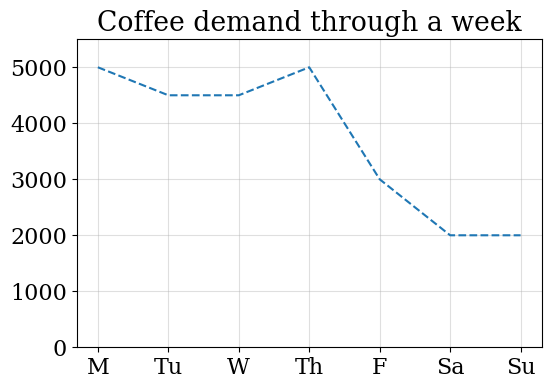

In [293]:
rc('font', **{'family': 'serif',
           'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su'], [5000*1, 5000*0.9, 5000*0.9, 5000*1, 5000*0.6, 5000*0.4, 5000*0.4], linestyle = '--')
plt.ylim((0, 5500))
plt.title('Coffee demand through a week')
plt.grid(alpha = 0.4)
plt.rcdefaults()

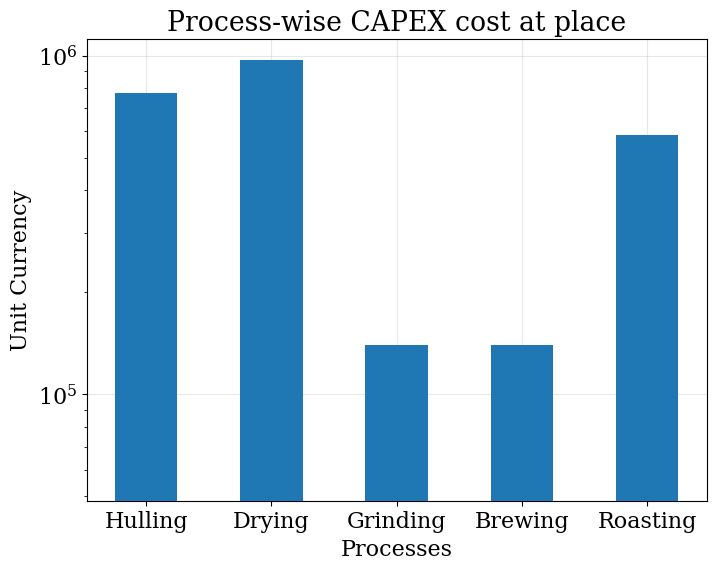

In [294]:
plot_results.cost(results= results, x = CostX.PROCESS_WISE, y = CostY.CAPEX, location= 'place', fig_size= (8,6))


In [295]:
results.output['global_warming_potential_resource']

{('place', 'coffee_cherries', 0): 2527777.7777777775,
 ('place', 'coffee_cherries', 1): 2527777.7777777775,
 ('place', 'coffee_cherries', 2): 2527777.7777777775,
 ('place', 'coffee_cherries', 3): 2527777.7777777775,
 ('place', 'coffee_cherries', 4): 2527777.7777777775,
 ('place', 'coffee_cherries', 5): 2527777.7777777775,
 ('place', 'coffee_cherries', 6): 2527777.7777777775,
 ('place', 'water', 0): 1455999.9999999998,
 ('place', 'water', 1): 1455999.9999999998,
 ('place', 'water', 2): 1455999.9999999998,
 ('place', 'water', 3): 1455999.9999999998,
 ('place', 'water', 4): 1455999.9999999998,
 ('place', 'water', 5): 1455999.9999999998,
 ('place', 'water', 6): 1455999.9999999998,
 ('place', 'power', 0): 10839111.111111104,
 ('place', 'power', 1): 10839111.111111104,
 ('place', 'power', 2): 10839111.111111104,
 ('place', 'power', 3): 10839111.111111104,
 ('place', 'power', 4): 10839111.111111104,
 ('place', 'power', 5): 10839111.111111104,
 ('place', 'power', 6): 10839111.111111104}

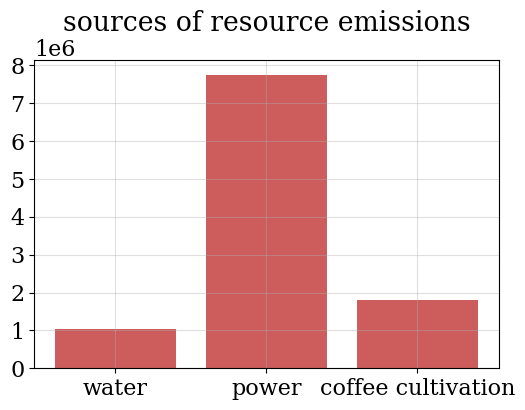

In [296]:
rc('font', **{'family': 'serif',
           'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (6,4))
ax.bar(['water', 'power', 'coffee cultivation'], [1040000, 7742222, 1805555], color = 'indianred')
# plt.ylim((0, 5500))
plt.title('sources of resource emissions')
plt.grid(alpha = 0.4)
plt.rcdefaults()

In [297]:
results.output['global_warming_potential_process']

{('place', 'Hulling', 0): 233333333.333333,
 ('place', 'Hulling', 1): 210000000.0,
 ('place', 'Hulling', 2): 210000000.0,
 ('place', 'Hulling', 3): 233333333.333333,
 ('place', 'Hulling', 4): 139999999.9999997,
 ('place', 'Hulling', 5): 93333333.33333285,
 ('place', 'Hulling', 6): 93333333.33333285,
 ('place', 'Drying', 0): 194444444.4444441,
 ('place', 'Drying', 1): 174999999.9999997,
 ('place', 'Drying', 2): 174999999.9999997,
 ('place', 'Drying', 3): 194444444.4444441,
 ('place', 'Drying', 4): 116666666.66666628,
 ('place', 'Drying', 5): 77777777.77777752,
 ('place', 'Drying', 6): 77777777.77777752,
 ('place', 'Grinding', 0): 420000000.0,
 ('place', 'Grinding', 1): 378000000.0,
 ('place', 'Grinding', 2): 378000000.0,
 ('place', 'Grinding', 3): 420000000.0,
 ('place', 'Grinding', 4): 252000000.0,
 ('place', 'Grinding', 5): 168000000.0,
 ('place', 'Grinding', 6): 168000000.0,
 ('place', 'Brewing', 0): 84000000.0,
 ('place', 'Brewing', 1): 75600000.0,
 ('place', 'Brewing', 2): 75600000

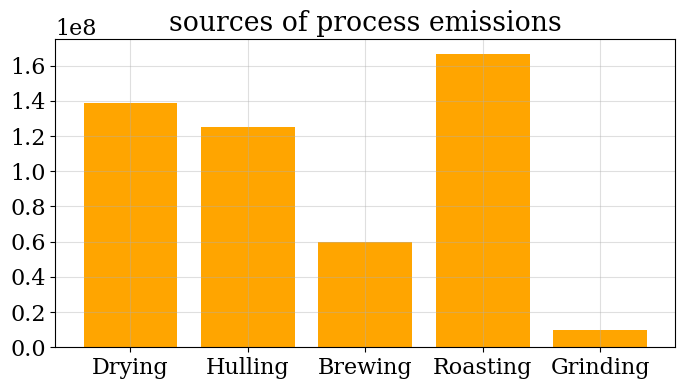

In [298]:
rc('font', **{'family': 'serif',
           'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (8,4))
ax.bar(['Drying', 'Hulling', 'Brewing', 'Roasting',  'Grinding'], [138888888, 124999999, 60000000, 166666666, 10000000], color = 'orange')
# plt.ylim((0, 5500))
plt.title('sources of process emissions')
plt.grid(alpha = 0.4)
plt.rcdefaults()